In [249]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [250]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [251]:
# index_col parameter required as the csv has an Id field that shouldn't be considered a feature 
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [252]:
train = train.drop([1299, 524,333])

In [253]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Filling NAs

In [254]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
PoolQC,99.657064
MiscFeature,96.399177
Alley,93.209877
Fence,80.452675
FireplaceQu,48.662551


In [255]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [256]:
#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [257]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [258]:
# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [259]:
#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [260]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

In [261]:
# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [262]:
#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [263]:
# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [264]:
# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [265]:
#SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [266]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [267]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# Adding some ordering to non-numeric categorical features

In [268]:
all_data["CentralAir"] = (all_data["CentralAir"] == "Y") * 1.0

In [269]:
 # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

all_data["ExterQual"] = all_data["ExterQual"].map(qual_dict).astype(int)
all_data["ExterCond"] = all_data["ExterCond"].map(qual_dict).astype(int)
all_data["BsmtQual"] = all_data["BsmtQual"].map(qual_dict).astype(int)
all_data["BsmtCond"] = all_data["BsmtCond"].map(qual_dict).astype(int)
all_data["HeatingQC"] = all_data["HeatingQC"].map(qual_dict).astype(int)
all_data["KitchenQual"] = all_data["KitchenQual"].map(qual_dict).astype(int)
all_data["FireplaceQu"] = all_data["FireplaceQu"].map(qual_dict).astype(int)
all_data["GarageQual"] = all_data["GarageQual"].map(qual_dict).astype(int)
all_data["GarageCond"] = all_data["GarageCond"].map(qual_dict).astype(int)

In [270]:
all_data["BsmtExposure"] = all_data["BsmtExposure"].map(
        {"None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

In [271]:
bsmt_fin_dict = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

In [272]:
all_data["Functional"] = all_data["Functional"].map(
        {"None": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

In [273]:
all_data["GarageFinish"] = all_data["GarageFinish"].map(
        {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

In [275]:
all_data["Fence"] = all_data["Fence"].map(
        {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

# Transforming some numerical variables that are really categorical

In [276]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
#all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
#all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [277]:
def preparaData(data):
    #numeric features:
    numeric_feats =data.dtypes[data.dtypes != "object"].index
    #log transform only numeric features:
    #skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    #skewed_feats = skewed_feats[skewed_feats > 0.75]
    
    data[numeric_feats] = np.log1p(data[numeric_feats]) # log transform data
    
    data = pd.get_dummies(data) 
    
    data = data.fillna(all_data.mean()) #filling NA's with the mean of the column:
    
    return data

In [278]:
all_data = all_data.loc[:,'MSSubClass':'SaleCondition']
all_data = preparaData(all_data)
all_data[:10]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,2.079442,1.791759,7.602900,7.602900,5.283204,1.609438,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,1.945910,2.197225,7.589336,7.589336,0.000000,1.386294,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,2.079442,1.791759,7.601902,7.602401,5.093750,1.609438,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,2.079442,1.791759,7.557995,7.586296,0.000000,1.386294,1.386294,1.386294,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,2.197225,1.791759,7.601402,7.601402,5.860786,1.609438,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
5,4.454347,9.555064,1.791759,1.791759,7.597898,7.598900,0.000000,1.386294,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
6,4.330733,9.218804,2.197225,1.791759,7.603399,7.603898,5.231109,1.609438,1.386294,1.791759,...,0,0,0,1,0,0,0,0,1,0
7,4.394449,9.247925,2.079442,1.945910,7.587817,7.587817,5.484797,1.386294,1.386294,1.609438,...,0,0,0,1,0,0,0,0,1,0
8,3.951244,8.719481,2.079442,1.791759,7.566311,7.576097,0.000000,1.386294,1.386294,1.386294,...,0,0,0,1,1,0,0,0,0,0
9,3.931826,8.912069,1.791759,1.945910,7.570443,7.576097,0.000000,1.386294,1.386294,1.386294,...,0,0,0,1,0,0,0,0,1,0


In [279]:
all_training_data = all_data[:train.shape[0]]
all_testing_data = all_data[train.shape[0]:]
all_training_label = np.log1p(train["SalePrice"])

In [280]:
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(all_training_data, all_training_label, test_size=0.1,random_state=42)

In [281]:
def drawPredictionAgainstReality(pred,reality):
    matplotlib.rc('xtick', labelsize=10) 
    matplotlib.rc('ytick', labelsize=10) 

    fig, ax = plt.subplots(figsize=(5, 5))

    plt.style.use('ggplot')
    plt.plot(pred, reality, 'ro')
    plt.xlabel('Predictions', fontsize = 10)
    plt.ylabel('Reality', fontsize = 10)
    plt.title('Predictions x Reality on dataset Test', fontsize = 15)
    ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
    
    plt.show()

In [282]:
from IPython.display import FileLink, FileLinks
def generateOutputFile(preds,fileName):
    my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': preds})
    my_submission.to_csv("../submissions/" + fileName, index=False)
    FileLink("../submissions/" + fileName)

In [283]:
from sklearn.model_selection import GridSearchCV

5.1
0.9306730356938541


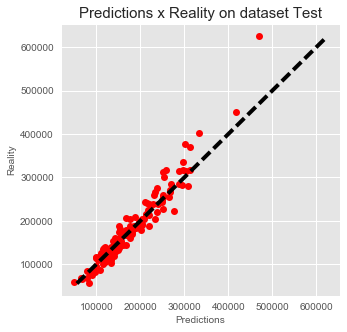

In [284]:
# Ridge Regulization
from sklearn.linear_model import Ridge
model = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 4.9,5,5.1,5.2,5.3,6,6.1,7,8,10, 15, 30, 50, 75]

grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(features_train, labels_train)

# summarize the results of the grid search
print(grid.best_estimator_.alpha)
print(grid.score(features_test, labels_test))
ridge_preds = np.expm1(grid.predict(features_test))

drawPredictionAgainstReality(ridge_preds,np.expm1(labels_test))

0.00045
random
215
0.9351192295434225


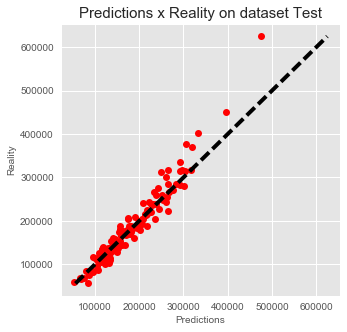

In [287]:
# Lasso Model
from sklearn.linear_model import Lasso
model = Lasso()
alphas = [0.0004,0.00044,0.00045,0.00046,0.0005]
selections = ["cyclic","random"]
max_iters = [215, 216,217,218,219,220,221,222,223]

gridlasso = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas,max_iter=max_iters,selection=selections))

gridlasso.fit(features_train, labels_train)

# summarize the results of the grid search
print(gridlasso.best_estimator_.alpha)
print(gridlasso.best_estimator_.selection)
print(gridlasso.best_estimator_.max_iter)
print(gridlasso.score(features_test, labels_test))

lasso_preds = np.expm1(gridlasso.predict(features_test))

drawPredictionAgainstReality(lasso_preds,np.expm1(labels_test))

lasso_test_preds = np.expm1(gridlasso.predict(all_testing_data))
#print(len(lasso_test_preds))
generateOutputFile(lasso_test_preds,"lasso_with_param_optimized.csv")

In [288]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm

param_test1 = {'n_estimators':range(20,81,10)} # tune best # of estimators
grid1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.15, min_samples_split=80,min_samples_leaf=50,max_depth=15,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1)
grid1.fit(features_train, labels_train)
print(grid1.best_estimator_.n_estimators)
grid1.score(features_test, labels_test)

80


0.9325446804440923

In [290]:
# tuning other params
param_test2 = {'max_depth':range(1,16,1), 'min_samples_split':range(10,100,10)}
grid2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.15, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2)
grid2.fit(features_train, labels_train)
print(grid2.best_estimator_.max_depth)
print(grid2.best_estimator_.min_samples_split)
grid2.score(features_test, labels_test)

5
70


0.9398857659871855

In [292]:
param_test3 = {'max_features':range(7,20,1)}
grid3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.14, n_estimators=80,max_depth=8, min_samples_split=70, subsample=0.85, random_state=10),
param_grid = param_test3)
grid3.fit(features_train, labels_train)
print(grid3.best_estimator_.max_features)

grid3.score(features_test, labels_test)

16


0.9408510529565942

In [294]:
param_test4 = {'learning_rate':[0.12,0.13,0.14,0.15,0.155]}
grid4 = GridSearchCV(estimator = GradientBoostingRegressor(max_features=16,n_estimators=80,max_depth=8, min_samples_split=70, subsample=0.85, random_state=10),
param_grid = param_test4)
grid4.fit(features_train, labels_train)
print(grid4.best_estimator_.learning_rate)

grid4.score(features_test, labels_test)

0.14


0.9408510529565942

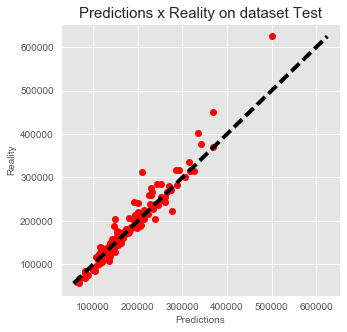

In [295]:
xdb_preds = np.expm1(grid4.predict(features_test))
drawPredictionAgainstReality(xdb_preds,np.expm1(labels_test))

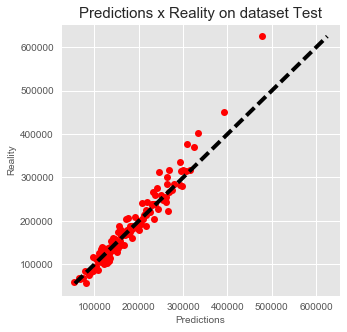

In [297]:
xdb_preds = 0.1*np.expm1(grid4.predict(features_test)) + 0.9*np.expm1(gridlasso.predict(features_test))
drawPredictionAgainstReality(xdb_preds,np.expm1(labels_test))